### Illustrative notebook : The MAB-VAE 

I advice to use a GPU provided by Google Colab' to make the computation time reasonable. In order to be able to run the code on collab', you will have to clone the repository and put somewhere in your Google Drive the library `MVAE.py`.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RonyAbecidan/VAE/blob/main/Experiments/MabVAE.ipynb)

In [2]:
#!pip install pytorch-lightning
#print("Please restart the runtime after installing pytorch-ligthning")

In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
#from google.colab import drive

#drive.mount('/content/drive')

# #path to the file where the library MVAE.py belongs to
# os.chdir('drive/MyDrive/VAE')

### In this notebook, we consider the following scenario : 

We want to construct a VAE for a particular generation problem (that could be easy or complex). We are pretty confident on the architecture of our encoder but not really for the decoder. Hence, we decide to design $K$ decoders and our goal will be to find among these decoders, which one is going to render the best result in the long term.

In order to solve the problem, I propose to use a classis multi-armed bandit strategy called the $\epsilon$ greedy-strategy. The idea is simple :

During the first epoch : I chose a decoder randomly among the set of decoders.

From the second epoch, at each step 

- with $\epsilon$ probability, we select a decoder randomly
- with 1-$\epsilon$ probability, we select the decoders that is known as the one having the minimum average reconstruction loss so far.

With this strategy, we could propose a certain number of decoders and see what is the one emerging after a few number of epochs.

### Importation of the datasets

Here, we are going to consider gradually complex datasets :

- The QMNIST dataset made of written numbers between 0 and 9
- The FashionMNIST dataset made of binarized clothes icons
- The CIFAR10 dataset made of RGB images of different kinds

All the images of these datasets have been resized to 32x32 to save time in the training phase.

In [10]:
transform =  transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

In [11]:
qmnist_trainset = datasets.QMNIST(root='./data', train=True, download=True, transform=transform)
qmnist_loader=DataLoader(qmnist_trainset, batch_size=128, shuffle=True, num_workers=0)

torch.Size([128, 1, 32, 32])


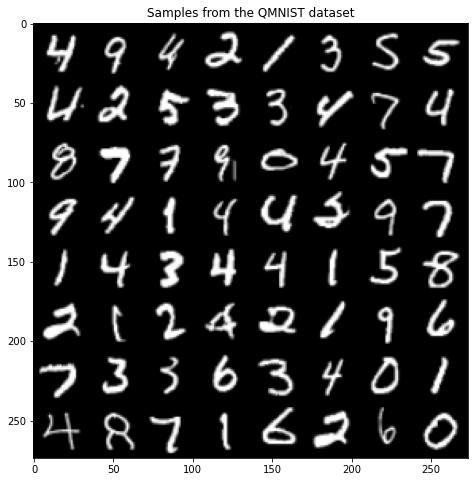

In [12]:
it=iter(qmnist_loader)
real_batch = next(iter(it))
plt.figure(figsize=(8,8))
print(real_batch[0].size())
plt.imshow(np.transpose(utils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.title('Samples from the QMNIST dataset');

#### MAB-VAE :

The code of the MAB-VAE is available in the library `MVAE.py` present in the repository.

Let us propose different type of decoders that we will use for the two first datasets. (We can't use exactly the same one for the last dataset because it is made of RGB images while the other images are binary).

Remark : The encoder is considered as fixed by simplicity => The latent_dim should be the same for all decoders

In [13]:
from MVAE import *

In [14]:
Decoders=nn.ModuleList([Decoder_MLP(latent_dim=100, in_channel=1, im_size=32, hiddens=[128,256,512]),
          Decoder_MLP(latent_dim=100, in_channel=1, im_size=32, hiddens=[256,512,1024]),
          Decoder_Conv(latent_dim=100, in_channel=1, im_size=32, hiddens=[1024,512,256,128],init=2),
          Decoder_Conv(latent_dim=100, in_channel=1, im_size=32, hiddens=[1024,512,256],init=4),
          Decoder_Linear_Conv(latent_dim=100, in_channel=1, im_size=32, hiddens=[512,256,128,64],init=2)])

#Creation of a MabVAE instance
MVAE = MabVAE(qmnist_loader,Decoders,eps=0.3,i=0)

**The details of the decoders architectures are in the library `MVAE.py`**

In [15]:
#We use the GPU for making computations faster
trainer = Trainer(gpus=1,max_epochs=5)
trainer.fit(MVAE)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | decoders | ModuleList | 28.9 M
1 | encoder  | Encoder    | 3.1 M 
----------------------------------------
32.0 M    Trainable params
0         Non-trainable params
32.0 M    Total params
127.901   Total estimated model params size (MB)


Epoch 0:  44%|████▍     | 206/469 [02:08<02:43,  1.61it/s, loss=1.95e+07, v_num=3]

#### Now the training is ended, let's see the decoder that has been called the most often

In [ ]:
MVAE.NbDraws/torch.sum(MVAE.NbDraws)

##### Conclusions and perspectives :

- Through this experiment we have seen that designing a MAB problem for making the search of an appropriate decoder could reveal to be really interesting. In just a few epochs and different problems/datasets, we have clearly seen that some decoders are more appropriate than others for a particular task and that it is not really possible to guess the best one by advance. Hence, solving such a problem can potentially really help a person to save time in the search of the best decoder architecture. However, I don't advise to rely on just one run of the algorithm since it involves some random process. In fact, there is a behaviour I observed that it's important to have in mind: The decoder which is the most often called at the beginning could be the one always chosen for the rest of the training if he has a considerable advance in the training. In order to mitigate this effect, I chose to initialize randomly the choice of the decoders for a while before using the epsilon greedy strategy which also helps for mitigating this phenomenon.

- Now, we could also imagine different couples of architectures for the encoders and the decoders while varying the dimensionality of the latent space. However, doing so will apply more computations and will take some times and I recall that the aim is to save time !

- It could be also a good idea to perform a Bayesian optimization for tuning the hyperparameters of a VAE such as the learning rate, the dimension of the latent size or the batch  size.

- We can also be tempted by changing the distribution of the decoders and hence, change our reconstruction loss. This can imply potentially better results. For instance, we could use a Gaussian decoder for RGB images normalized between -1 and 1 and the MSE Loss as our reconstruction loss.